Anomaly Detection in Time Series Data with Keras

- Coursera Resource: [Anomaly Detection source](https://www.coursera.org/learn/anomaly-detection-time-series-keras/home/welcome)

Anomaly Detection in Time Series Data with Keras using S&P 500 Index Data 
- Tasks involves are:


1.   Task 1: Import Libraries
2.   Task 2: Load and Inspect the S&P 500 Index Data
3.   Task 3: Data Preprocessing
4. Task 4: Temporalize Data and Create Training and Test Splits
5. Task 5: Build an LSTM Autoencoder
6. Task 6: Train the Autoencoder
7. Task 7: Plot Metrics and Evaluate the Model
8. Task 8: Detect Anomalies in the S&P 500 Index Data

Introduction to Anomaly Detection in Time Series with Keras
- Task 1: Import Libraries


In [2]:
# import relevant libraries

import numpy as np
import tensorflow as tf
import pandas as pd
pd.options.mode.chained_assignment = None
import seaborn as sns
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

%matplotlib inline

sns.set(style='whitegrid', palette='muted')
rcParams['figure.figsize'] = 14, 8
np.random.seed(1)
tf.random.set_seed(1)

print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.3.0


Task 2: Load and Inspect the S&P 500 Index Data

In [3]:
# Load the datasets, read the first five rows and parse the dates  

df = pd.read_csv('S&P_500_Index_Data.csv', parse_dates=['date'])
df.head()

,date,close
0,1986-01-02,209.59
1,1986-01-03,210.88
2,1986-01-06,210.65
3,1986-01-07,213.80
4,1986-01-08,207.97


In [4]:
# Take a look at the number of rows and columns (rows = 8192, columns = 2)

df.shape

(8192, 2)

In [5]:
# Create an interactive plot using plotly

fig = go.Figure()
fig.add_trace(go.Scatter(x=df.date, y=df.close, mode='lines', name='close'))
fig.update_layout(showlegend=True)
fig.show()

Task 3: Data Preprocessing

In [6]:
# Splitting the dataset into training and test datasets

train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(train.shape, test.shape)

(6553, 2) (1639, 2)


In [7]:
# Using sklearn to split the close price columns

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler =scaler.fit(train[['close']])

train['close'] = scaler.transform(train[['close']])
test['close'] = scaler.transform(test[['close']])

Task 4: Create Training and Test Splits

In [8]:
def create_sequences(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
      Xs.append(X.iloc[i:(i+time_steps)].values)
      ys.append(y.iloc[i:(i+time_steps)])
    return np.array(Xs), np.array(ys)

In [10]:
# Create timesteps and call the function created earlier

time_steps=30

X_train, y_train = create_sequences(train[['close']], train.close, time_steps)
X_test, y_test = create_sequences(test[['close']], test.close, time_steps)

In [11]:
print(X_train.shape)

(6523, 30, 1)


Task 5: Build an LSTM Autoencoder

In [12]:
timesteps = X_train.shape[1]
num_features = X_train.shape[2]

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

model = Sequential([
  LSTM(128, input_shape=(timesteps, num_features)),
  Dropout(0.2),
  RepeatVector(timesteps),
  LSTM(128, return_sequences=True),
  Dropout(0.2),
  TimeDistributed(Dense(num_features))
])

model.compile(loss='mae', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               66560     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 30, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 128)           131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 128)           0         
_________________________________________________________________
time_distributed (TimeDistri (None, 30, 1)             129       
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
__________________________________________________

Task 6: Train the Autoencoder

In [14]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    callbacks = [es],
    shuffle=False
)

Epoch 1/100
184/184 [==============================] - 14s 76ms/step - loss: 0.1634 - val_loss: 0.0992
Epoch 2/100
184/184 [==============================] - 13s 72ms/step - loss: 0.0987 - val_loss: 0.1234
Epoch 3/100
184/184 [==============================] - 13s 72ms/step - loss: 0.0879 - val_loss: 0.1839
Epoch 4/100
184/184 [==============================] - 13s 73ms/step - loss: 0.0898 - val_loss: 0.0719
Epoch 5/100
184/184 [==============================] - 13s 72ms/step - loss: 0.1097 - val_loss: 0.0648
Epoch 6/100
184/184 [==============================] - 13s 72ms/step - loss: 0.1176 - val_loss: 0.0709
Epoch 7/100
184/184 [==============================] - 13s 72ms/step - loss: 0.1258 - val_loss: 0.0688
Epoch 8/100
184/184 [==============================] - 13s 71ms/step - loss: 0.1356 - val_loss: 0.0999


Task 7: Plot Metrics and Evaluate the Model

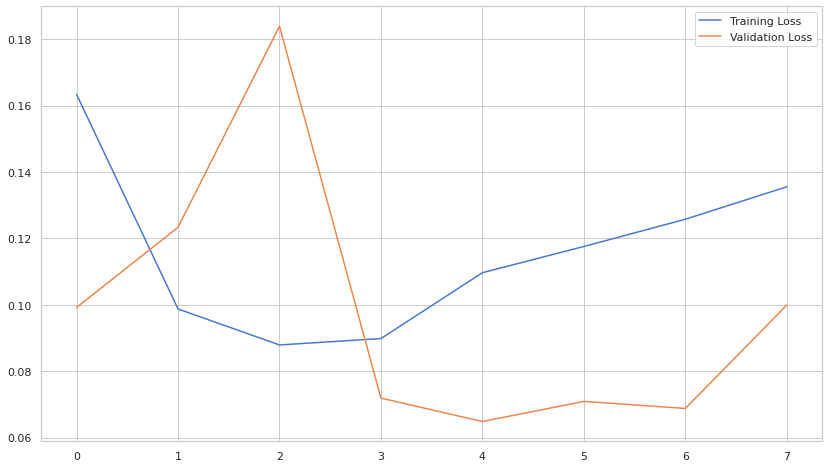

In [15]:
# Ploting the training and validation loss
 
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend();

In [16]:
X_train_pred = model.predict(X_train)

train_mae_loss = pd.DataFrame(np.mean(np.abs(X_train_pred - X_train), axis=1), columns=['Error']) 

In [17]:
model.evaluate(X_test, y_test)

51/51 [==============================] - 1s 20ms/step - loss: 0.6208


0.6208398342132568

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



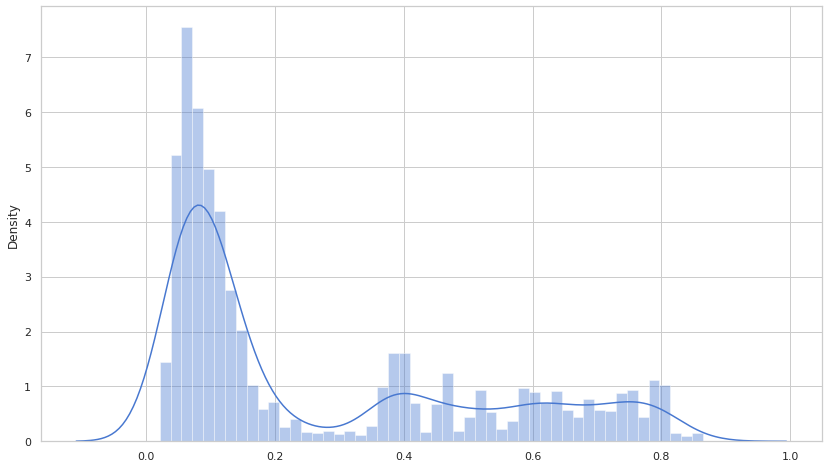

In [18]:
# Distribution of the errors

sns.distplot(train_mae_loss, bins=50, kde=True);

In [19]:
# You can come back to tweak the threshold value

threshold = 0.65

In [20]:
X_test_pred = model.predict(X_test)
test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

Task 8: Detect Anomalies in the S&P 500 Index Data

In [21]:
test_score_df = pd.DataFrame(test[time_steps:])
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = threshold
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['close'] = test[time_steps:].close

In [22]:
test_score_df.head()

,date,close,loss,threshold,anomaly
6583,2012-02-08,1.216856,0.127951,0.65,False
6584,2012-02-09,1.221625,0.128935,0.65,False
6585,2012-02-10,1.199313,0.128774,0.65,False
6586,2012-02-13,1.221194,0.121343,0.65,False
6587,2012-02-14,1.218150,0.119552,0.65,False


In [23]:
test_score_df.tail()

,date,close,loss,threshold,anomaly
8187,2018-06-25,4.493228,1.951088,0.65,True
8188,2018-06-26,4.507583,1.958466,0.65,True
8189,2018-06-27,4.451431,1.961419,0.65,True
8190,2018-06-28,4.491406,1.966332,0.65,True
8191,2018-06-29,4.496343,1.965273,0.65,True


In [24]:
# Create an interactive plot  for Test and Threshold Loss

fig = go.Figure()
fig.add_trace(go.Scatter(x=test[time_steps:].date, y=test_score_df.loss,
                        mode='lines', name="Test Loss"))

# Plot threshold line 0.65

fig.add_trace(go.Scatter(x=test[time_steps:].date, y=test_score_df.threshold,
                        mode='lines', name="Threshold Loss"))

fig.update_layout(showlegend=True)
fig.show()

In [25]:
anomalies= test_score_df[test_score_df.anomaly == True]
anomalies.head()

,date,close,loss,threshold,anomaly
7370,2015-03-27,2.920959,0.653354,0.65,True
7371,2015-03-30,2.981401,0.655322,0.65,True
7410,2015-05-26,3.024443,0.650166,0.65,True
7411,2015-05-27,3.070649,0.659393,0.65,True
7412,2015-05-28,3.064202,0.660104,0.65,True


In [26]:
# Create an interactive plot
# Change the y using scaler.inverse method to reverse the changes made earlier

fig = go.Figure()
fig.add_trace(go.Scatter(x=test[time_steps:].date, y=scaler.inverse_transform(test[time_steps:].close),
                        mode='lines',name='Close price'))

fig.add_trace(go.Scatter(x=anomalies.date, y=scaler.inverse_transform(anomalies.close),
                        mode='markers', name="Anomaly"))

fig.update_layout(showlegend=True)
fig.show()